# Download data set zip file

In [15]:
!! wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

['--2023-03-30 21:39:16--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
 'Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...',
 'Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 68606236 (65M) [application/zip]',
 'Saving to: ‘cats_and_dogs_filtered.zip.1’',
 '',
 '',
 '          cats_and_   0%[                    ]       0  --.-KB/s               ',
 '         cats_and_d  64%[===========>        ]  42.04M   210MB/s               ',
 'cats_and_dogs_filte 100%[===================>]  65.43M   225MB/s    in 0.3s    ',
 '',
 '2023-03-30 21:39:17 (225 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]',
 '']

# Extract data from zip file

In [16]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Import Used packages

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd

# Get data of specific data set path



In [ ]:
def create_dataset(path):
  images_paths=[]
  images_labels=[]
  for dir in os.listdir(path):
    for file in os.listdir(f'{path}/{dir}'):
      images_paths.append(f'{path}/{dir}/{file}')
      images_labels.append( 0 if dir=='cats' else 1)
  
  images_paths=np.array(images_paths)
  images_labels=np.array(images_labels)
  return images_paths, images_labels

# Get pathes of train and validation data sets

In [ ]:
image_train , label_train=create_dataset('/content/cats_and_dogs_filtered/train')
image_validation, label_validation=create_dataset('/content/cats_and_dogs_filtered/validation')

print(image_train)

['/content/cats_and_dogs_filtered/train/dogs/dog.579.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.92.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.313.jpg' ...
 '/content/cats_and_dogs_filtered/train/cats/cat.798.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.228.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.377.jpg']


# Change image into tensor

In [ ]:
def getImageTensorFromPath(image_path, image_label):
  image=tf.io.read_file(image_path)
  image=tf.image.decode_jpeg(image)
  image=tf.image.convert_image_dtype(image, tf.float32)
  image=tf.image.resize(image,(244,244))

  return image , image_label

# Create augmanted function to increase the size of training data to get better preformance

In [ ]:
# this function will be called only on training data set
def augmented_image(image, image_label):
  image=tf.image.random_flip_left_right(image)
  image=tf.image.random_flip_up_down(image)
  image=tf.image.random_brightness(image, max_delta=32.0/255.0)
  image=tf.image.random_saturation(image, lower=0.5, upper=1.5)
  
  return image , image_label

# Create tensor data set

In [ ]:
def dataset(image, label, batch_size=32, training=False):
  data=tf.data.Dataset.from_tensor_slices((image,label))
  
  data=data.map(getImageTensorFromPath,num_parallel_calls=tf.data.experimental.AUTOTUNE)

  if training:
    data=data.map(augmented_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  data=data.shuffle(2000)
  data=data.batch(batch_size)     # divide the data into batches
  data=data.prefetch(tf.data.experimental.AUTOTUNE) #prepare the rest of the data
  return data

# Prepare the data set of training



In [ ]:
train_dataset= dataset(image_train, label_train, training= True)
validation_dataset= dataset(image_validation, label_validation)

# Build the model

In [ ]:
model = tf.keras.Sequential([
    #First block
    tf.keras.layers.Input(shape=(244,244, 3)), # design input layer with 
    tf.keras.layers.Conv2D(64, 3 , activation=tf.nn.relu,padding='same'), # 32 indicates number of filters
    tf.keras.layers.MaxPool2D(),

    #Second block
    tf.keras.layers.Conv2D(10, 3 , activation=tf.nn.relu,padding='same'), # 32 indicates number of filters
    tf.keras.layers.MaxPool2D(),
    
    #Third block
    tf.keras.layers.Conv2D(9, 3 , activation=tf.nn.relu,padding='same'), # 9 indicates number of filters
    tf.keras.layers.MaxPool2D(),

    #Fourth block
    tf.keras.layers.Conv2D(5, 3 , activation=tf.nn.relu,padding='same'), 
    tf.keras.layers.MaxPool2D(),

    #Fifth block
    tf.keras.layers.Conv2D(4, 3 , activation=tf.nn.relu,padding='same'),
    tf.keras.layers.MaxPool2D(),

    #flatten the network
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=80, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid, name='output_layer'), #one output as it is binary classificatin

])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 244, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 10)      5770      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 9)         819       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 9)        0

# Train the model on the training data set

In [ ]:
model.compile('adam', loss='binary_crossentropy', metrics=['acc'])

model.fit(train_dataset, batch_size=32, epochs=15, validation_data=validation_dataset)

Epoch 1/15
63/63 [==============================] - 294s 5s/step - loss: 0.5567 - acc: 0.7200 - val_loss: 0.5649 - val_acc: 0.7140
Epoch 2/15
63/63 [==============================] - 311s 5s/step - loss: 0.5478 - acc: 0.7245 - val_loss: 0.5406 - val_acc: 0.7270
Epoch 3/15
63/63 [==============================] - 296s 5s/step - loss: 0.5317 - acc: 0.7385 - val_loss: 0.5593 - val_acc: 0.7270
Epoch 4/15
63/63 [==============================] - 320s 5s/step - loss: 0.5362 - acc: 0.7345 - val_loss: 0.5512 - val_acc: 0.7250
Epoch 5/15
63/63 [==============================] - 309s 5s/step - loss: 0.5253 - acc: 0.7520 - val_loss: 0.5591 - val_acc: 0.7230
Epoch 6/15
63/63 [==============================] - 308s 5s/step - loss: 0.5186 - acc: 0.7400 - val_loss: 0.5297 - val_acc: 0.7400
Epoch 7/15
63/63 [==============================] - 299s 5s/step - loss: 0.5164 - acc: 0.7460 - val_loss: 0.5247 - val_acc: 0.7490
Epoch 8/15
63/63 [==============================] - 305s 5s/step - loss: 0.5238 - a

# Plotting error graph for training and validation data

<Axes: >

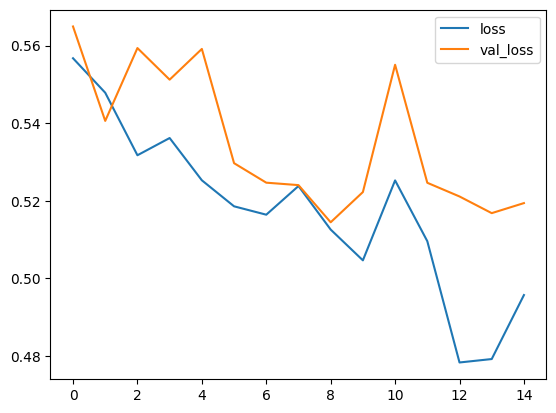

In [ ]:
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot.line()